In [14]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score

In [15]:


# Global parameters
nr = 101
days = 30
seconds_per_day = 60 * 60 * 24
tf = days * seconds_per_day
nout = days // 3 + 1
tout = np.linspace(0, tf, nout)
r = np.linspace(0, 0.5, nr)

In [16]:
def pde_1(u, t, r, u0, D, sc, p):
    """
    PDE for wound healing model.

    Parameters:
    u : array, solution at current time
    t : float, current time
    r : array, spatial grid
    u0 : float, initial condition at r=0
    D : float, diffusion coefficient
    sc : float, source term coefficient
    p : float, nonlinearity exponent

    Returns:
    ut : array, time derivative of u
    """
    nr = len(r)
    ut = np.zeros(nr)
    u[0] = u0  # Boundary condition at r=0

    # First derivatives
    ur = np.zeros(nr)
    dr = r[1] - r[0]
    ur[1:-1] = (u[2:] - u[:-2]) / (2 * dr)
    ur[0] = (u[1] - u[0]) / dr
    ur[-1] = 0  # Boundary condition at r=r_max

    # Second derivatives
    urr = np.zeros(nr)
    urr[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dr**2
    urr[0] = (2 * u[1] - 2 * u[0]) / dr**2
    urr[-1] = (-2 * ur[-1] * (r[-1] - r[-2]) + 2 * (u[-2] - u[-1])) / (r[-1] - r[-2])**2

    # PDE computation
    for i in range(1, nr):
        try:
            f1 = 1 - u[i] / u0
            if f1 < 0 and p % 1 != 0:
                f1 = np.abs(f1)
            if p > 0:
                term1 = D * (f1**p * urr[i] + p * f1**(p - 1) * (-1 / u0) * ur[i]**2)
            else:
                term1 = D * urr[i]
        except Exception as e:
            print(f"PDE issue at r index {i}, value={u[i]}: {e}")
            term1 = 0
        term2 = sc * u[i] * (1 - u[i] / u0)
        ut[i] = term1 + term2

    ut[0] = 0  # No change at r=0
    return ut

In [17]:
# Define cases
cases = [
    {'case': 0, 'r0': 0.5, 'u0': 1.0, 'D': 2.0e-9, 'sc': 0.0,     'p': 0},
    {'case': 1, 'r0': 0.5, 'u0': 1.0, 'D': 2.0e-9, 'sc': 8.0e-6,  'p': 0},
    {'case': 2, 'r0': 0.5, 'u0': 1.0, 'D': 2.0e-9, 'sc': 8.0e-6,  'p': 1},
    {'case': 3, 'r0': 0.5, 'u0': 1.0, 'D': 2.0e-9, 'sc': 8.0e-6,  'p': 5}
]

# Initialize list to store dataframes
all_dfs = []

# Run simulations for each case
for case in cases:
    cid = case['case']
    r0 = case['r0']
    u0 = case['u0']
    D = case['D']
    sc = case['sc']
    p = case['p']

    print(f"\n🔄 Running case {cid}...")

    # Initial condition
    u_initial = np.zeros(nr)
    u_initial[0] = u0

    # Solve PDE
    solution = odeint(pde_1, u_initial, tout, args=(r, u0, D, sc, p))

    # Create meshgrid for output
    t_days = tout / seconds_per_day
    T, R = np.meshgrid(t_days, r, indexing='ij')
    U = solution

    # Store results in dataframe
    df = pd.DataFrame({
        'case': cid,
        'r': R.flatten(),
        't': T.flatten(),
        'u': U.flatten(),
        'r0': r0,
        'u0': u0,
        'D': D,
        'sc': sc,
        'p': p
    })

    all_dfs.append(df)


🔄 Running case 0...

🔄 Running case 1...

🔄 Running case 2...

🔄 Running case 3...


<ipython-input-17-4047424239>:28: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(pde_1, u_initial, tout, args=(r, u0, D, sc, p))


In [18]:
# Combine and save results
if all_dfs:
    df_all = pd.concat(all_dfs, ignore_index=True)
    df_all = df_all.sample(frac=1.0, random_state=42).reset_index(drop=True)
    df_all.to_csv('wound_healing_nn_data.csv', index=False, float_format='%.6e')
    print("✅ Data generated and saved to 'wound_healing_nn_data.csv'")
else:
    print("No valid data was generated.")

✅ Data generated and saved to 'wound_healing_nn_data.csv'


In [19]:
df = pd.read_csv('wound_healing_nn_data.csv')
df.shape

(4444, 9)

In [20]:
X = df[['r', 't', 'D', 'sc', 'p']].values
y = df['u'].values.reshape(-1, 1)
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


In [21]:



model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output: u
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [22]:
history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_split=0.1, verbose=1)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.6473 - mae: 0.7706 - val_loss: 0.0591 - val_mae: 0.1977
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0743 - mae: 0.2169 - val_loss: 0.0315 - val_mae: 0.1348
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0304 - mae: 0.1333 - val_loss: 0.0198 - val_mae: 0.1059
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178 - mae: 0.0996 - val_loss: 0.0107 - val_mae: 0.0707
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089 - mae: 0.0661 - val_loss: 0.0065 - val_mae: 0.0523
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0487 - val_loss: 0.0045 - val_mae: 0.0408
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0350 - val_loss: 0.0034 - val_mae: 0.0309
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mae: 0.0260 - val_loss: 0.0029 - val_mae: 0.0249
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0420e-05 - mae: 0.0052 
Test MAE: 0.0054


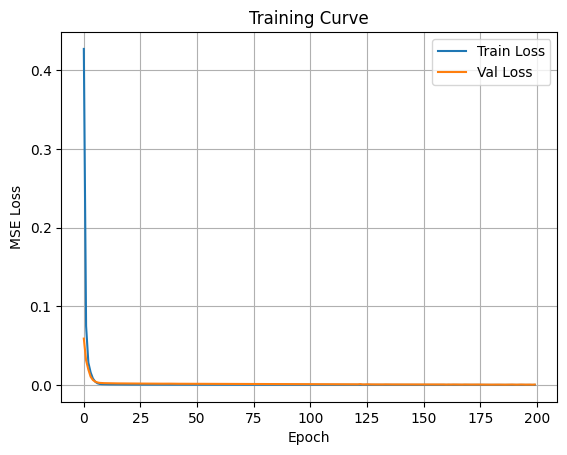

In [23]:

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.title('Training Curve')
plt.show()


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


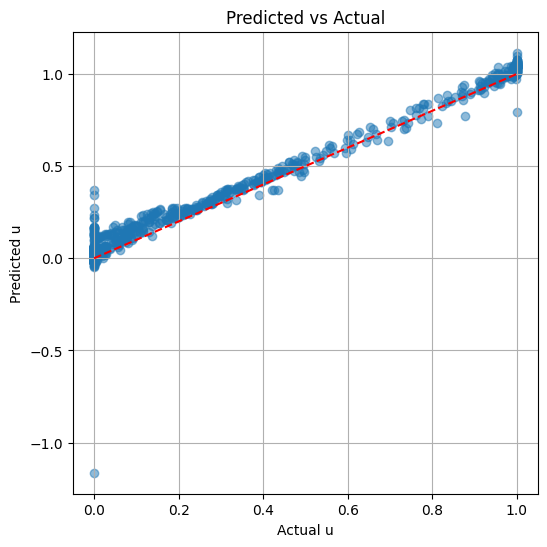

In [24]:
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_original = y_scaler.inverse_transform(y_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.xlabel("Actual u")
plt.ylabel("Predicted u")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.plot([0,1],[0,1], 'r--')
plt.show()


In [25]:
r2 = r2_score(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(y_pred_scaled))
print(f"R² Score: {r2:.4f}")


R² Score: 0.9700


In [26]:
model.save('skindeep_supervised.h5')